In [92]:
import sys
print(sys.executable)


c:\Users\Asus\AppData\Local\Programs\Python\Python314\python.exe


In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

In [94]:
df = pd.read_csv("../data/online_retail.csv", encoding="ISO-8859-1")


In [95]:
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [96]:
df.shape

(541909, 8)

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Data Loading Summary
The dataset was loaded into a Python DataFrame using Pandas, and the notebook is now able to interact with it.
Initial inspection confirms transaction-level data containing customer, product, pricing, and time information.

| Column      | Meaning                    |
| ----------- | -------------------------- |
| InvoiceNo   | Unique invoice number      |
| StockCode   | Product identifier         |
| Description | Product description        |
| Quantity    | Number of units purchased  |
| InvoiceDate | Date & time of transaction |
| UnitPrice   | Price per unit             |
| CustomerID  | Unique customer ID         |
| Country     | Customer country           |


In [98]:
df.isnull().sum()


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Data Quality Observation
Missing values are present in CustomerID and Description columns. Since customer-level analysis requires valid customer identifiers, records without CustomerID will be handled during the data cleaning phase.

In [99]:
df=df.dropna(subset=["CustomerID"])

In [100]:
df["CustomerID"].isnull().sum()


np.int64(0)

In [101]:
df=df.drop_duplicates()

In [102]:
df.duplicated().sum()


np.int64(0)

In [103]:
df[df["Quantity"]<=0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


In [104]:
df[df["UnitPrice"]<=0].head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647.0,Germany
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560.0,United Kingdom
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911.0,EIRE
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom


In [105]:
df=df[(df["Quantity"]>0)&(df["UnitPrice"]>0)]


In [106]:
df["CustomerID"].isnull().sum()

np.int64(0)

In [107]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

In [108]:
df["TotalAmount"]=df["Quantity"]*df["UnitPrice"]

In [109]:
df["TotalAmount"].head()


0    15.30
1    20.34
2    22.00
3    20.34
4    20.34
Name: TotalAmount, dtype: float64

In [110]:
df.shape
df.describe()
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [111]:
df.shape


(392692, 9)

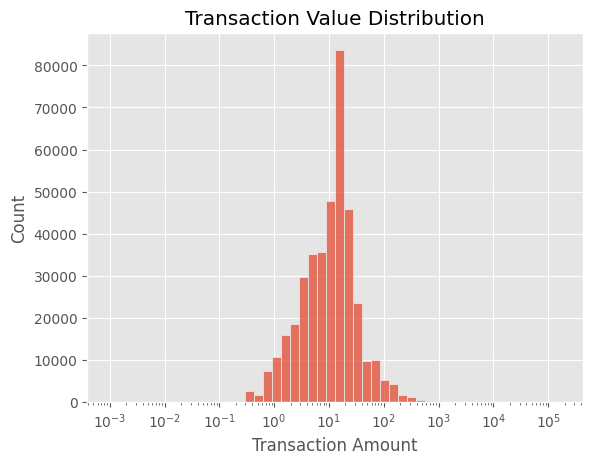

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df["TotalAmount"], bins=50, log_scale = True)
plt.title("Transaction Value Distribution")
plt.xlabel("Transaction Amount")
plt.ylabel("Count")
plt.show()

Overall Transaction Value Distribution

Without the log scale, most values are right skewed.
This shows most purchases are low value and a few are high value.



[]

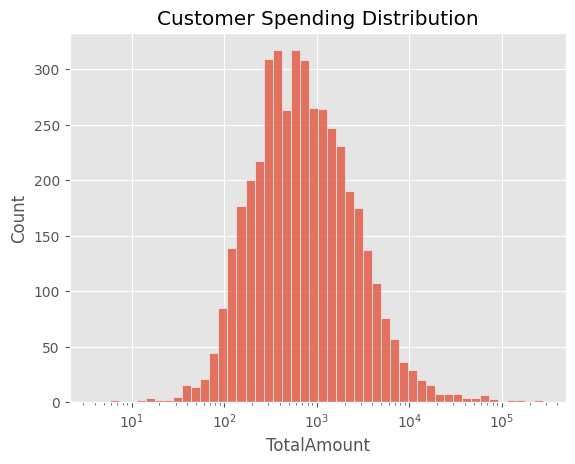

In [113]:
customer_spend = df.groupby("CustomerID")["TotalAmount"].sum()
sns.histplot(customer_spend, bins=50,log_scale = True)
plt.title("Customer Spending Distribution")
plt.plot()

A small group of customers contribute disproportionately to total revenue

[]

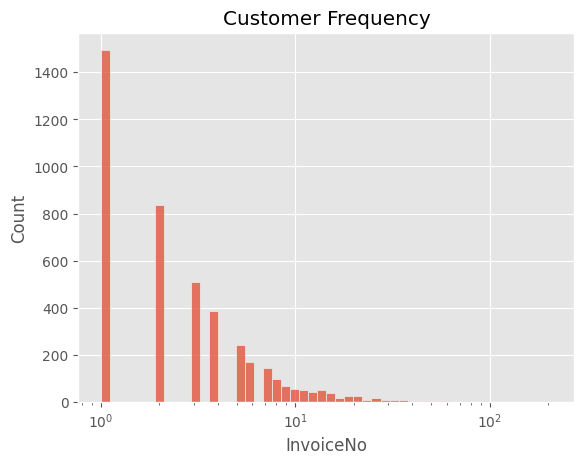

In [114]:
customer_frequency = df.groupby("CustomerID")["InvoiceNo"].nunique()
sns.histplot(customer_frequency, bins=50, log_scale = True)
plt.title("Customer Frequency")
plt.plot()

Most customers purchase infrequently, while a minority represent high frequency


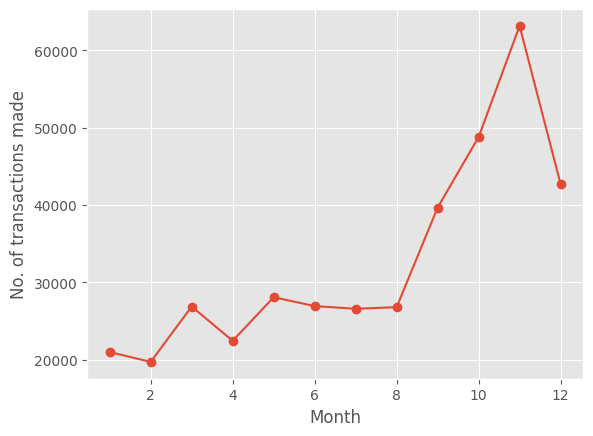

In [115]:
df["Month"]=df["InvoiceDate"].dt.month

monthly_txn=df.groupby("Month")["InvoiceNo"].count()
monthly_txn.plot(kind="line", marker ="o")
plt.xlabel("Month")
plt.ylabel("No. of transactions made")
plt.show()


Most purchases were made in the month of November, i.e at the end of the year, and least purchases are made in the month of February, i.e at the beginnning of the year.


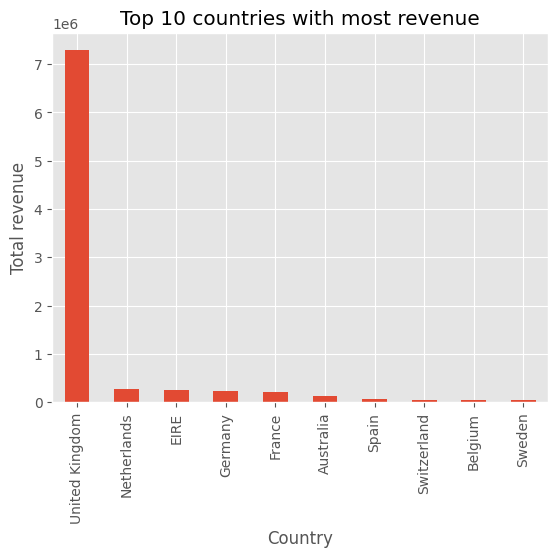

In [116]:
country_revenue = df.groupby("Country")["TotalAmount"].sum().sort_values(ascending=False).head(10)

country_revenue.plot(kind="bar")
plt.xlabel("Country")
plt.ylabel("Total revenue")
plt.title("Top 10 countries with most revenue")
plt.show()



We notice that maximum revenue is generated from UK, and least revenue from Sweden

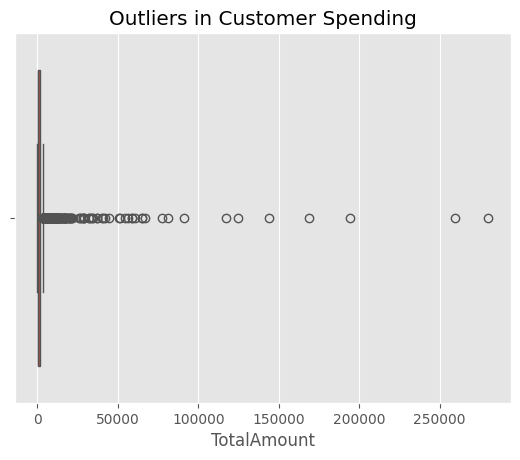

In [117]:
sns.boxplot(x=customer_spend)
plt.title("Outliers in Customer Spending")
plt.show()

Extreme outliers were capped to prevent distortion in clustering analysis.

In [118]:
import datetime as dt

snapshot_date = df["InvoiceDate"].max() + dt.timedelta(days=1)
snapshot_date

rfm=df.groupby("CustomerID").agg({
    "InvoiceDate":lambda x: (snapshot_date - x.max()).days,
    "InvoiceNo":"nunique",
    "TotalAmount":"sum"
})

rfm.columns = ["Recency","Frequency","Monetary"]

rfm.head()
rfm.describe()

,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,92.536422,4.272015,2048.688081
std,100.014169,7.697998,8985.230220
min,1.000000,1.000000,3.750000
25%,18.000000,1.000000,306.482500
50%,51.000000,2.000000,668.570000
75%,142.000000,5.000000,1660.597500
max,374.000000,209.000000,280206.020000


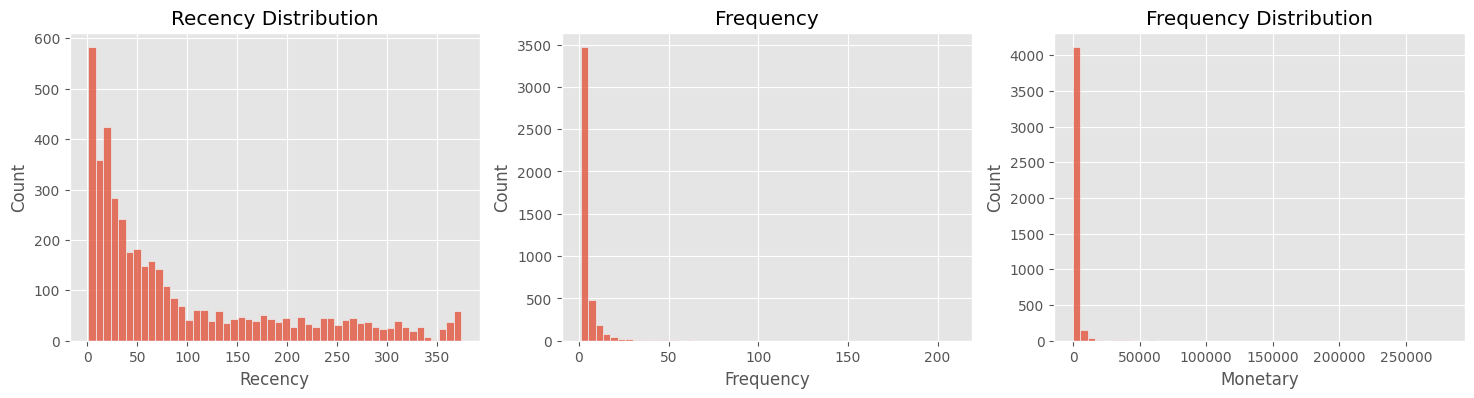

In [119]:
fig, axes = plt.subplots(1,3, figsize = (18,4))

sns.histplot(rfm["Recency"],bins=50, ax=axes[0])
axes[0].set_title("Recency Distribution")

sns.histplot(rfm["Frequency"], bins=50, ax=axes[1])
axes[1].set_title("Frequency")

sns.histplot(rfm["Monetary"], bins=50, ax=axes[2])
axes[2].set_title("Frequency Distribution")

plt.show()



Recency, frequency, and monetary values show significant skewness, indicating distinct customer behavior patterns and the need for segmentation.

In [120]:
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [ ]:
#scalinf rfm features

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

rfm_scaled.shape

(4338, 3)

In [124]:
#finding optimal number of clusters

from sklearn.cluster import KMeans

sse = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)


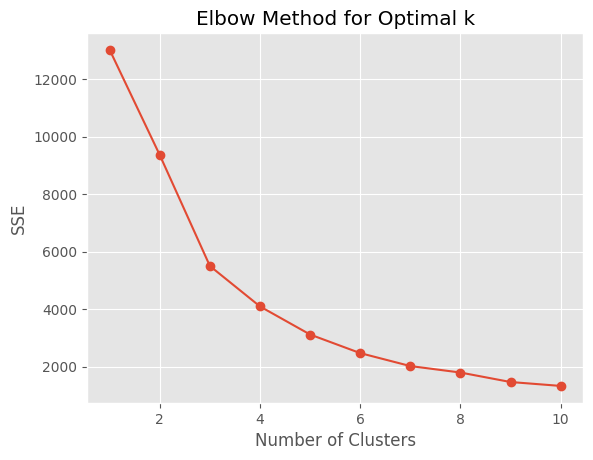

In [125]:
plt.plot(range(1, 11), sse, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title("Elbow Method for Optimal k")
plt.show()


In [126]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)


In [127]:
cluster_summary = rfm.groupby("Cluster").mean()
cluster_summary


,Recency,Frequency,Monetary
Cluster,,,
0,43.702685,3.682711,1353.625312
1,248.075914,1.552015,478.848773
2,7.384615,82.538462,127187.959231
3,15.500000,22.333333,12690.500392


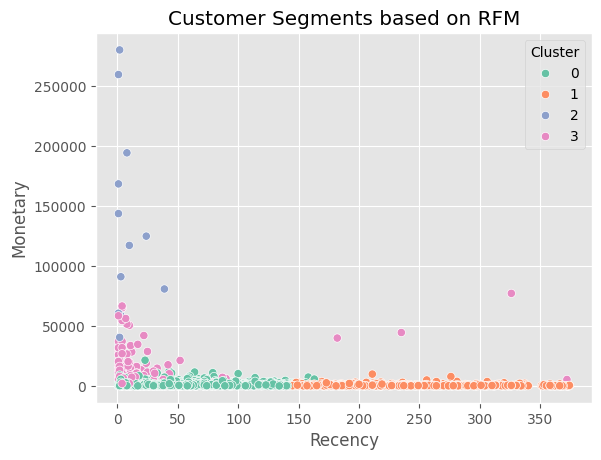

In [128]:
sns.scatterplot(
    x="Recency",
    y="Monetary",
    hue="Cluster",
    data=rfm,
    palette="Set2"
)
plt.title("Customer Segments based on RFM")
plt.show()


In [131]:
#Now starting with purchase propensity prediction

future_window = 30
last_date = df["InvoiceDate"].max()
future_df = df[df["InvoiceDate"] > last_date - pd.Timedelta(days=future_window)]

future_customers = future_df["CustomerID"].unique()
rfm["PurchasedNext30Days"] = rfm.index.isin(future_customers).astype(int)

X = rfm[["Recency", "Frequency", "Monetary"]]
y = rfm["PurchasedNext30Days"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))





              precision    recall  f1-score   support

           0       1.00      1.00      1.00       673
           1       1.00      1.00      1.00       412

    accuracy                           1.00      1085
   macro avg       1.00      1.00      1.00      1085
weighted avg       1.00      1.00      1.00      1085

ROC AUC: 1.0


In [132]:
cutoff_date = df["InvoiceDate"].max() - pd.Timedelta(days=30)

snapshot_date = cutoff_date + pd.Timedelta(days=1)

rfm_fixed = df[df["InvoiceDate"] <= cutoff_date].groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
    "InvoiceNo": "nunique",
    "TotalAmount": "sum"
})

rfm_fixed.columns = ["Recency", "Frequency", "Monetary"]

future_df = df[df["InvoiceDate"] > cutoff_date]
future_customers = future_df["CustomerID"].unique()

rfm_fixed["PurchasedNext30Days"] = (
    rfm_fixed.index.isin(future_customers)
).astype(int)

X = rfm_fixed[["Recency", "Frequency", "Monetary"]]
y = rfm_fixed["PurchasedNext30Days"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [133]:
from sklearn.metrics import classification_report, roc_auc_score

y_prob = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.74      0.92      0.82       673
           1       0.70      0.36      0.47       345

    accuracy                           0.73      1018
   macro avg       0.72      0.64      0.65      1018
weighted avg       0.73      0.73      0.70      1018

ROC AUC: 0.7345263475246031


Key Business Insights

Customer behavior analysis revealed four distinct customer segments with clearly different purchasing patterns, enabling more focused and efficient marketing strategies.

A high-value segment was identified, characterized by frequent purchases, higher spending, and recent activity, making them ideal candidates for loyalty programs and personalized offers.

Customers with low recency and high frequency demonstrated the highest likelihood of making repeat purchases within the next 30 days.

The purchase propensity model delivered realistic predictive performance, providing reliable insights into which customers are most likely to convert in the near term.

These insights can be leveraged to prioritize high-probability customers, reduce marketing spend on low-value segments, and improve overall customer retention.



In [134]:
import pandas as pd

importance = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

importance


segment_conversion = (
    rfm_fixed
    .merge(rfm[["Cluster"]], left_index=True, right_index=True)
    .groupby("Cluster")["PurchasedNext30Days"]
    .mean()
)

segment_conversion


Cluster
0    0.423546
1    0.000000
2    0.923077
3    0.921569
Name: PurchasedNext30Days, dtype: float64